In [ ]:
import torch, torchvision
from torch import nn
from torch.nn import functional as F
from torchvision import transforms

import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import tqdm
import os

import random

This notebook accompanies the [week15] practice. Refer to the classwork for more details.


Your last and ultimate task is to implement and train __Convolutional Conditional VAE__. Simple VAE is available in week 15. For details about conditional VAE one can refer to [week 15 lecture](https://github.com/ml-mipt/ml-mipt/tree/advanced/week15_generative) or [this habr post (ru)](https://habr.com/ru/post/331664/)

If it seems too easy, you can use [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset instead of MNIST.

The code in general duplicates the one from the in-class practice. 

Do not forget to __use GPU acceleration during training__.

In [ ]:
%matplotlib inline

In [ ]:
from torchsummary import summary
import seaborn as sns
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

__Currently you are using device:__

In [ ]:
print(device)

cuda:0


In [ ]:
# It's dangerous to walk alone. Take these ;)

class Rescale(object):
    def __call__(self, image):
        image = image - image.min()
        image = image/image.max()

        return image
    
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return torch.flatten(x, start_dim=1, end_dim=-1)


class RestoreShape(nn.Module):
    def __init__(self, initial_shape):
        super().__init__()
        self.initial_shape = initial_shape
        
    def forward(self, x):
        return x.view([-1]+list(self.initial_shape))

__Data loading stuff is done for you ;)__

In [ ]:
mnist_transformations = transforms.Compose([
    transforms.ToTensor(),
    Rescale()
])

In [ ]:
BATCH_SIZE = 2048
SHUFFLE_DATASET = True
NUM_DATALOADER_WORKERS = 1

In [ ]:
data_root = './'

In [ ]:
train_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=True,
        transform=mnist_transformations,
        download=True
    ),
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DATASET,
    num_workers=NUM_DATALOADER_WORKERS
)

In [ ]:
test_loader = torch.utils.data.DataLoader(
    dataset=torchvision.datasets.MNIST(
        root=data_root,
        train=False,
        transform=mnist_transformations
    ),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_DATALOADER_WORKERS
)

__The code below is simple VAE. Your task is to make in convolutional (both encoder and decoder) and add class label information.__

In [ ]:
class ConvolutionalCVAE(nn.Module):
    def __init__(self, intermediate_dims, latent_dim):
        super().__init__()
        self.nz = latent_dim

        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 2, 64 * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64 * 4, 1024, 4, 1, 0, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1124, 64 * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(64 * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 8, 64 * 4, 3, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 4, 64 * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64 * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(64 * 2,     1, 4, 2, 1, bias=False),
            nn.Sigmoid()
        )

        self.fc1 = nn.Linear(1124, 512)
        self.fc21 = nn.Linear(512, self.nz)
        self.fc22 = nn.Linear(512, self.nz)

        self.fc3 = nn.Linear(self.nz, 512)
        self.fc4 = nn.Linear(512, 1024)

        self.lrelu = nn.LeakyReLU()
        self.relu = nn.ReLU()

        self.label_enc = nn.Embedding(10, 100)
        self.label_dec = nn.Embedding(10, 100)

    def _encode(self, x, c):
        conv = self.encoder(x);
        flat = torch.cat([conv.view(-1, 1024), self.label_enc(c)], dim=1)
        h1 = self.fc1(flat)
        return self.fc21(h1), self.fc22(h1)

    def _decode(self, z, c):
        h3 = self.relu(self.fc3(z))
        deconv_input = self.fc4(h3)
        deconv_input = deconv_input.view(-1,1024,1,1)
        label_vec = self.label_dec(c).view(-1, 100, 1, 1)
        deconv_input = torch.cat([deconv_input, label_vec], dim=1)
        return self.decoder(deconv_input)

    def _reparametrize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        eps = torch.randn(std.size(), requires_grad=True, device=mu.device)
        return eps.mul(std).add_(mu)

    def forward(self, x, c):
        mu, logvar = self._encode(x, c)
        z = self._reparametrize(mu, logvar)
        decoded = self._decode(z, c)
        return decoded, z, mu, logvar

In [ ]:
def plot_digits(*args):
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    
    fig = plt.figure(figsize=(2*n, 2*len(args)))
    for j in range(n):
        for i in range(len(args)):
            ax = plt.subplot(len(args), n, i*n + j + 1)
            plt.imshow(args[i][j])
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)
    return fig


In [ ]:
example_batch = next(iter(train_loader))
example_batch = [x.to(device) for x in example_batch]
example_x = example_batch[0][0]

model = ConvolutionalCVAE([256, 128], 2).to(device)
opt = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_func = torch.nn.modules.loss.BCELoss()

reconstructed_repr, latent_sample, mu_values, log_sigma_values = model(example_batch[0][:15].to(device), example_batch[1][:15].to(device))


\begin{aligned}
D_{K L}[Q(z | X) \| P(z | X)] &=\sum_{z} Q(z | X) \log \frac{Q(z | X)}{P(z | X)} \\
&=E\left[\log \frac{Q(z | X)}{P(z | X)}\right] \\
&=E[\log Q(z | X)-\log P(z | X)]
\end{aligned}

\begin{aligned}
D_{K L}[Q(z | X) \| P(z | X)] &=E\left[\log Q(z | X)-\log \frac{P(X | z) P(z)}{P(X)}\right] \\
&=E[\log Q(z | X)-(\log P(X | z)+\log P(z)-\log P(X))] \\
&=E[\log Q(z | X)-\log P(X | z)-\log P(z)+\log P(X)]
\end{aligned}

The expectation is over $z$ and $P(X)$ doesn't depend on $z,$ so we could move it outside of the expectation

\begin{aligned}
D_{K L}[Q(z | X) \| P(z | X)] &=E[\log Q(z | X)-\log P(X | z)-\log P(z)]+\log P(X) \\
D_{K L}[Q(z | X) \| P(z | X)]-\log P(X) &=E[\log Q(z | X)-\log P(X | z)-\log P(z)]
\end{aligned}

\begin{aligned}
D_{K L}[Q(z | X) \| P(z | X)]-\log P(X) &=E[\log Q(z | X)-\log P(X | z)-\log P(z)] \\
\log P(X)-D_{K L}[Q(z | X) \| P(z | X)] &=E[\log P(X | z)-(\log Q(z | X)-\log P(z))] \\
&=E[\log P(X | z)]-E[\log Q(z | X)-\log P(z)] \\
&=E[\log P(X | z)]-D_{K L}[Q(z | X) \| P(z)]
\end{aligned}

And this is it, the VAE objective function:

$$
\log P(X)-D_{K L}[Q(z | X) \| P(z | X)]=E[\log P(X | z)]-D_{K L}[Q(z | X) \| P(z)]
$$

$$
D_{K L}[N(\mu(X), \Sigma(X)) \| N(0,1)]=\frac{1}{2}\left(\operatorname{tr}(\Sigma(X))+\mu(X)^{T} \mu(X)-k-\log \operatorname{det}(\Sigma(X))\right)
$$
Above, $k$ is the dimension of our Gaussian. $\operatorname{tr}(X)$ is trace function, i.e. sum of the diagonal of matrix $X$. The determinant of a diagonal matrix could be computed as product of its diagonal. So really, we could implement $\Sigma(X)$ as just a vector as it's a diagonal matrix:

\begin{aligned}
D_{K L}[N(\mu(X), \Sigma(X)) \| N(0,1)] &=\frac{1}{2}\left(\sum_{k} \Sigma(X)+\sum_{k} \mu^{2}(X)-\sum_{k} 1-\log \prod_{k} \Sigma(X)\right) \\
&=\frac{1}{2}\left(\sum_{k} \Sigma(X)+\sum_{k} \mu^{2}(X)-\sum_{k} 1-\sum_{k} \log \Sigma(X)\right) \\
&=\frac{1}{2} \sum_{k}\left(\Sigma(X)+\mu^{2}(X)-1-\log \Sigma(X)\right)
\end{aligned}


In [ ]:
n = 15 # to generate image with 15x15 examples
digit_size = 28
latent_dim = 2
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

def draw_manifold(model, c, show=True):
    figure = np.zeros((digit_size * n, digit_size * n))
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z_sample = np.zeros((1, latent_dim))
            z_sample[:, :2] = np.array([[xi, yi]])
            
            z_torch = torch.from_numpy(z_sample).type(torch.FloatTensor).to(device)
            #if c is not None:
            c = torch.LongTensor([c]*z_torch.size(0)).to(device)
            x_decoded = model._decode(z_torch, c).detach().cpu().numpy()
            digit = x_decoded[0].squeeze()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit
    if show:
        plt.figure(figsize=(15, 15))
        plt.imshow(figure, cmap='Greys_r')
#         plt.grid(None)
        ax = plt.gca()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)        
        plt.show()
    return figure

In [ ]:
def get_test_predictions(model, test_loader):
    model.eval()
    reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list = [], [], [], []
    for test_batch in tqdm.tqdm_notebook(test_loader, leave=False):
        out = model(test_batch[0].to(device), test_batch[1].to(device))
        reconstructed_repr, latent_sample, mu_values, log_sigma_values = [x.detach().cpu() for x in out]
        reconstructed_repr_list.append(reconstructed_repr)
        latent_samples_list.append(latent_sample)
        mu_values_list.append(mu_values)
        log_sigma_values_list.append(log_sigma_values)
    return [
        torch.cat(_list, dim=0)
        for _list in [reconstructed_repr_list, latent_samples_list, mu_values_list, log_sigma_values_list]
    ]

In [ ]:
def on_epoch_end(epoch):
    # Saving manifold and z distribution to build plots and animation afterwards
    figure = draw_manifold(model, 1, show=False)
    reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)
    return figure, reconstructed_repr, latent_sample, mu_values, log_sigma_values

In [ ]:

def train(num_epochs):
    epochs, figs, latent_distrs = [], [], []
    for epoch_num in tqdm.tnrange(num_epochs):
        model.train()
        loss_accumulator = 0.
        bce_acc = 0.
        kl_acc = 0.
        for batch_x, batch_label in tqdm.tqdm_notebook(train_loader, leave=False):
            batch_x = batch_x.to(device)
            c = batch_label.to(device)
            predictions, latent, mu_values, log_sigma_values = model(batch_x, c)

            kl_loss = -0.5 * (1 + log_sigma_values - mu_values.pow(2) - log_sigma_values.exp()).mean(0).sum()
            bce_loss = 28*28*loss_func(predictions, batch_x)
            loss = (bce_loss + kl_loss)/2./28./28.
            loss.backward()
            opt.step()
            opt.zero_grad()

            loss_accumulator += loss.item()/(len(train_loader.dataset))
            bce_acc += bce_loss.item()/(len(train_loader.dataset))
            kl_acc += kl_loss.item()/(len(train_loader.dataset))

        if epoch_num % 5 == 0:
            print('Epoch num: {}\nTraining loss={:.4f}, KL divergence={:.4f}, BCE Loss={:.4f}'.format(
                epoch_num,
                loss_accumulator,
                kl_acc,
                bce_acc
            ))
            model.eval()
            figure, reconstructed_repr_test, latent_sample_test, mu_values_test, log_sigma_values_test = on_epoch_end(epoch_num)
            epochs.append(epoch_num)
            figs.append(figure)
            latent_distrs.append((mu_values_test, log_sigma_values_test))
    return epochs, figs, latent_distrs

In [ ]:
epochs, figs, latent_distrs = train(15)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  after removing the cwd from sys.path.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


Epoch num: 0
Training loss=0.0001, KL divergence=0.0106, BCE Loss=0.1662


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


Epoch num: 5
Training loss=0.0000, KL divergence=0.0020, BCE Loss=0.0693


Epoch num: 10
Training loss=0.0000, KL divergence=0.0022, BCE Loss=0.0650


In [ ]:
test_batch = next(iter(test_loader))

In [ ]:
reconstructed_repr, latent_sample, mu_values, log_sigma_values = get_test_predictions(model, test_loader)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


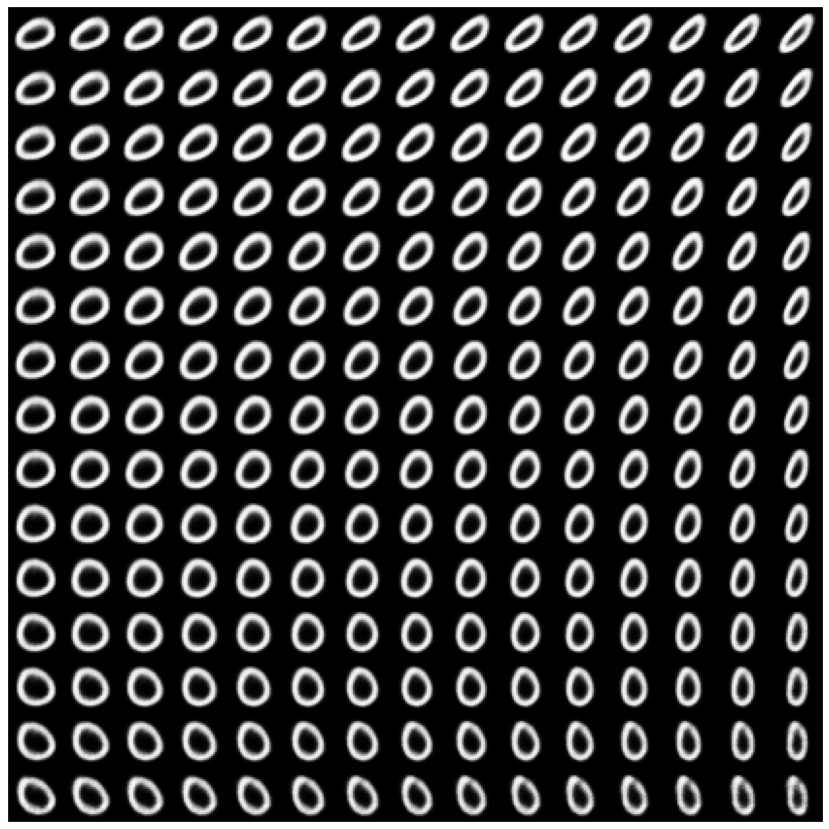

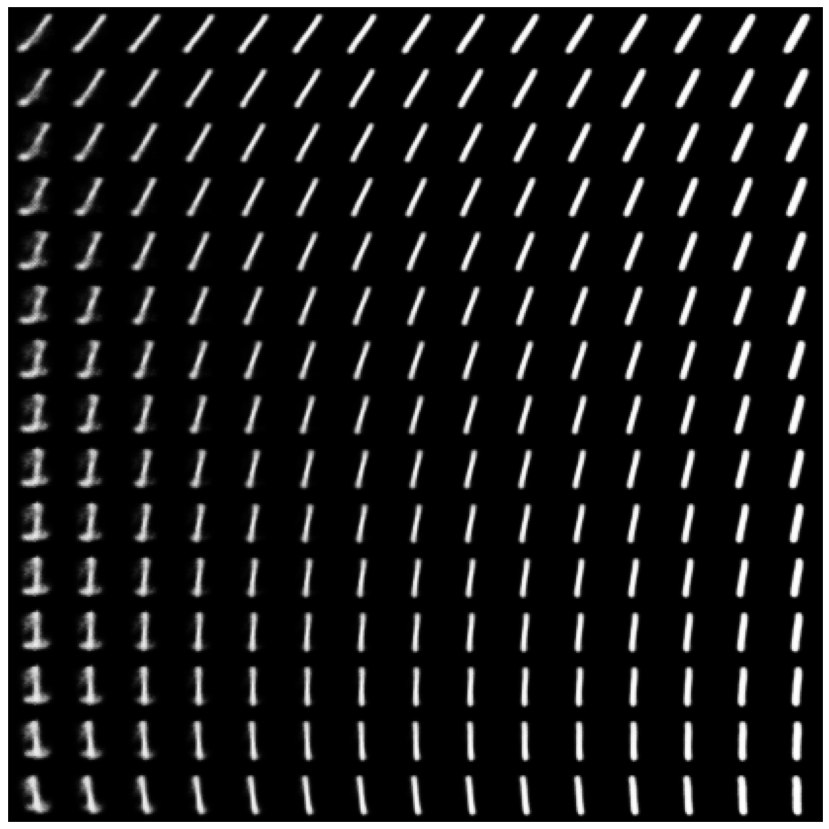

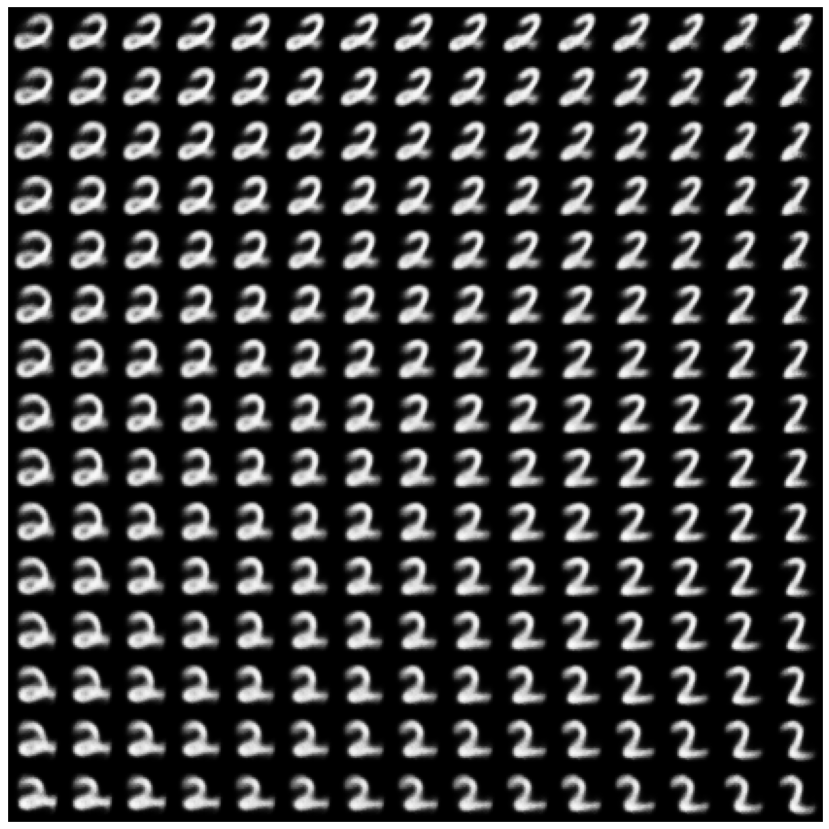

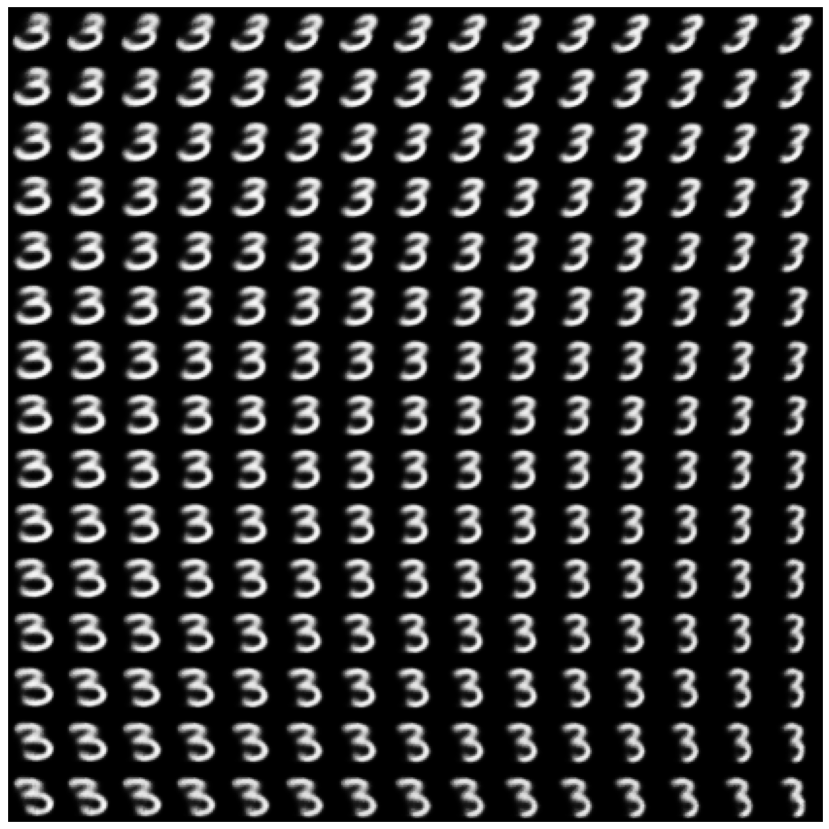

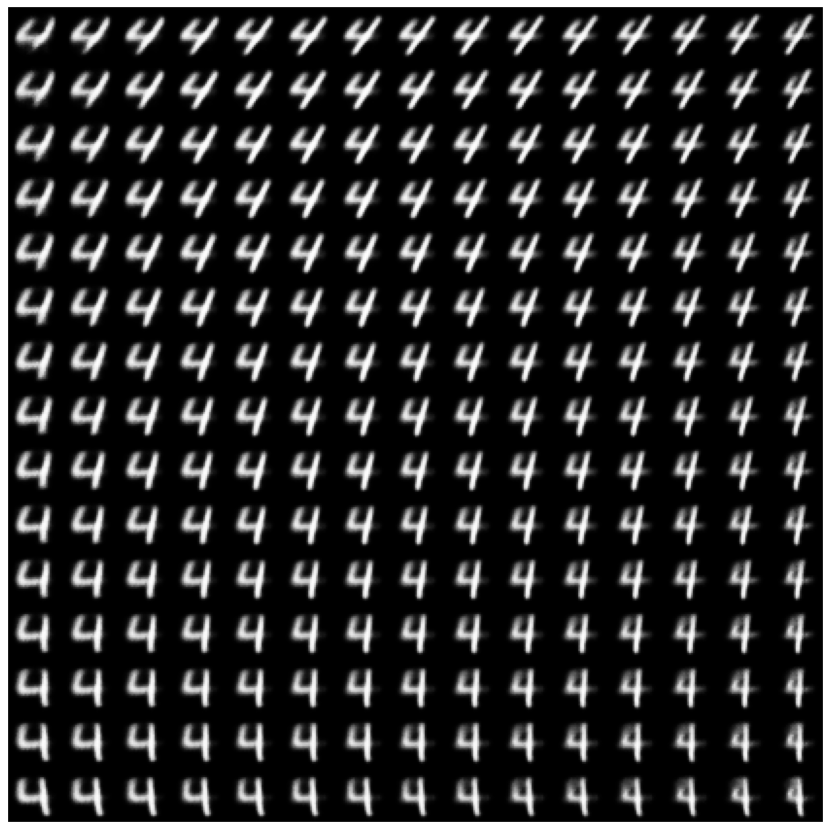

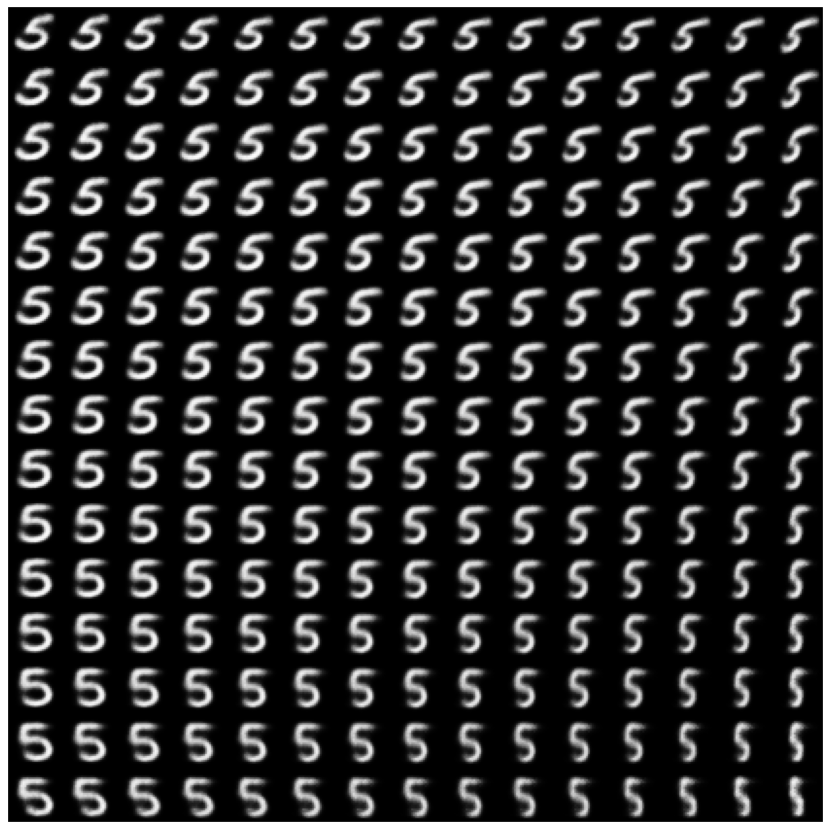

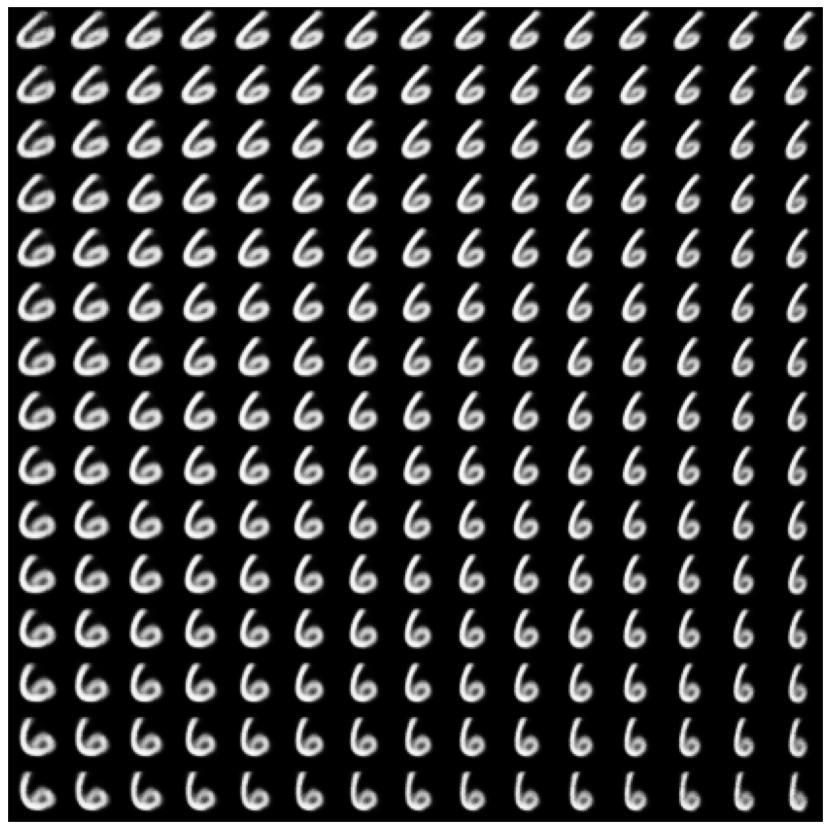

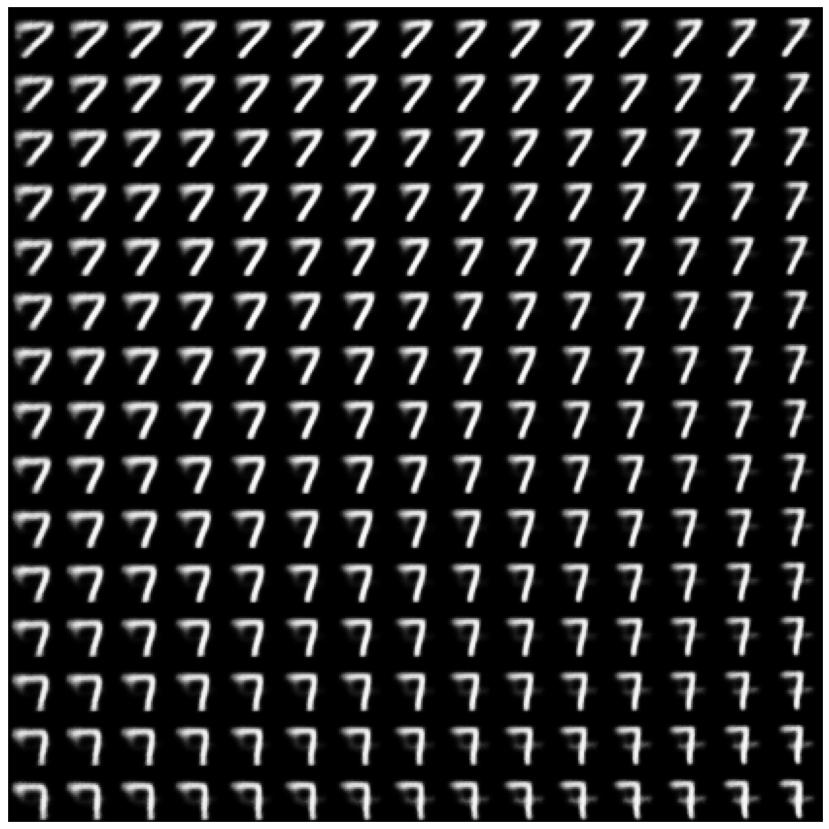

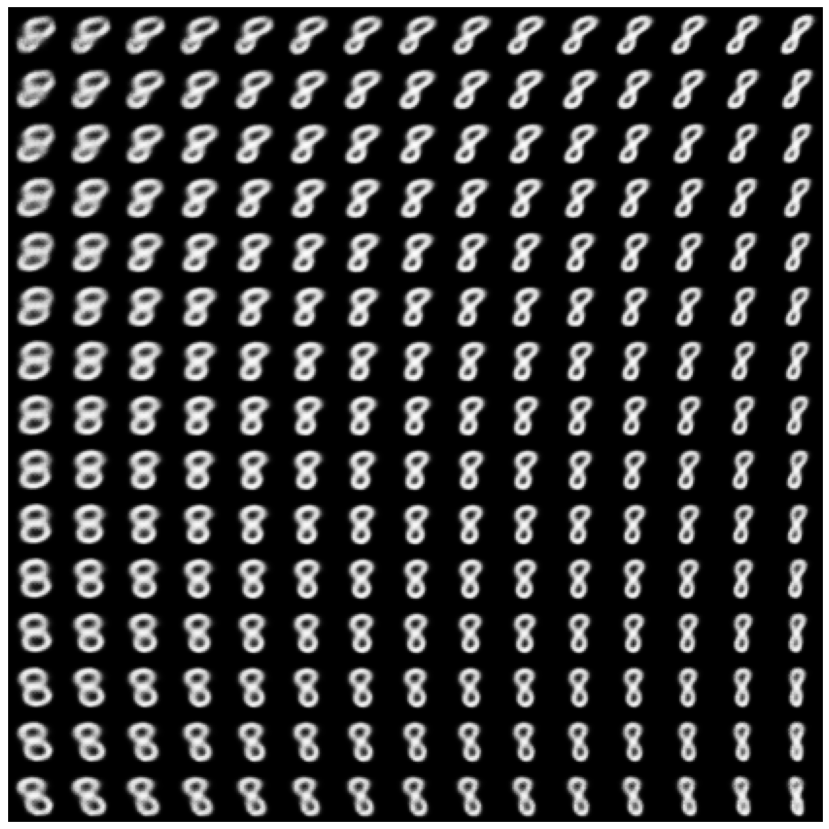

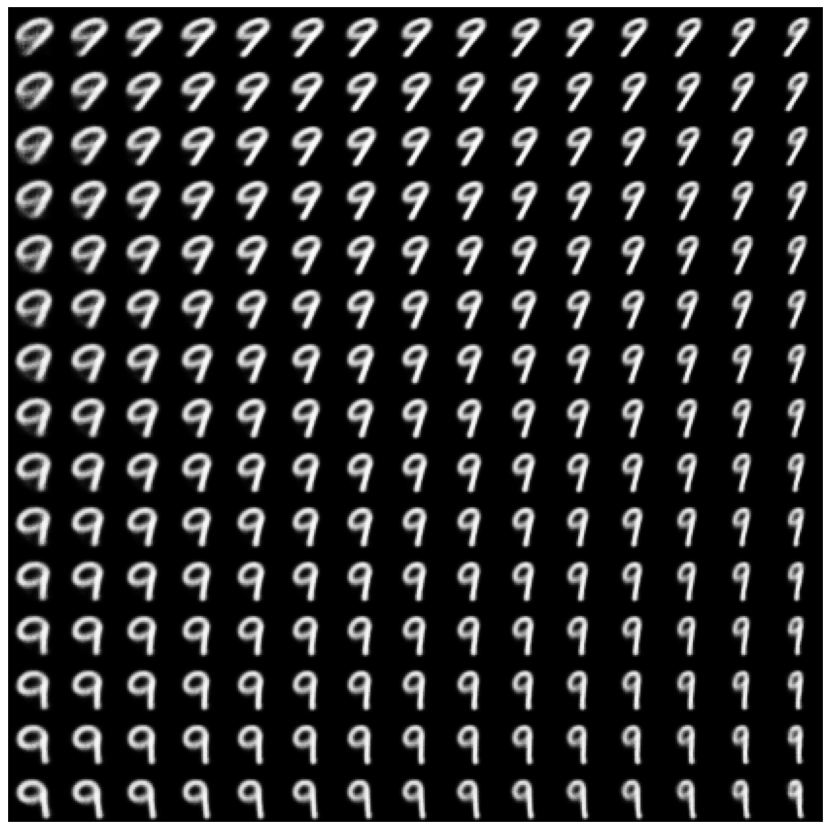

In [ ]:
model.eval()
#_img = draw_manifold(model, show=True)

for c in range(10):
   #model.eval()
   _img = draw_manifold(model, c=c, show=True)

In [ ]:
test_labels = []
for b in test_loader:
    test_labels.append(b[1])
test_labels = torch.cat(test_labels, dim=0).numpy()

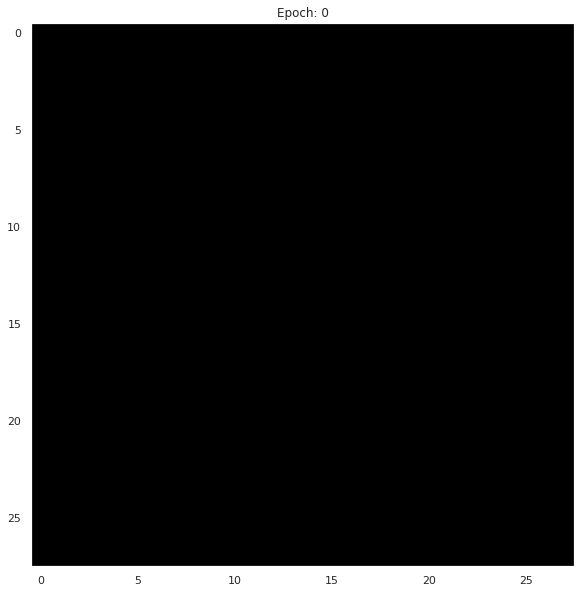

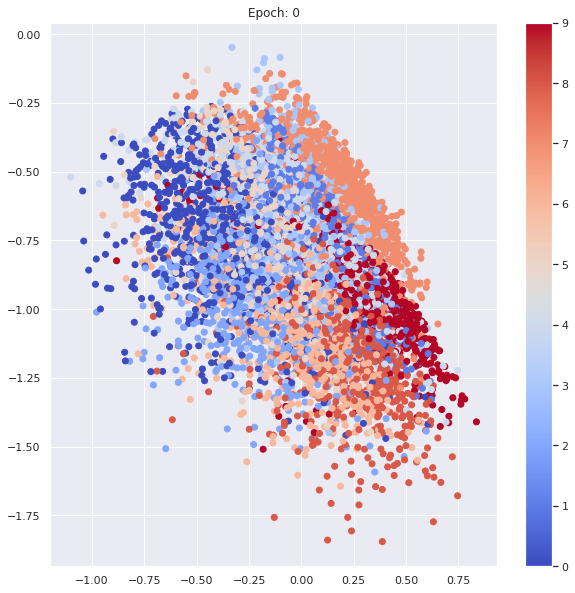

In [ ]:
import os
os.makedirs('my_figs', exist_ok=True)

from matplotlib.animation import FuncAnimation
from matplotlib import cm
import matplotlib

def make_2d_figs_gif(figs, epochs, fname, fig): 
    norm = matplotlib.colors.Normalize(vmin=0, vmax=1, clip=False)
    im = plt.imshow(np.zeros((28,28)), cmap='Greys_r', norm=norm)
    plt.grid(None)
    plt.title("Epoch: " + str(epochs[0]))

    def update(i):
        im.set_array(figs[i])
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        return im
    
    anim = FuncAnimation(fig, update, frames=range(len(figs)), interval=100)
    #anim.save(fname, dpi=80, writer='imagemagick')

def make_2d_scatter_gif(zs, epochs, c, fname, fig):
    im = plt.scatter(zs[0][:, 0], zs[0][:, 1], c=c, cmap=cm.coolwarm)
    plt.colorbar()
    plt.title("Epoch: " + str(epochs[0]))
    def update(i):
        fig.clear()
        im = plt.scatter(zs[i][:, 0], zs[i][:, 1], c=c, cmap=cm.coolwarm)
        im.axes.set_title("Epoch: " + str(epochs[i]))
        im.axes.set_xlim(-5, 5)
        im.axes.set_ylim(-5, 5)
        return im

    anim = FuncAnimation(fig, update, frames=range(len(zs)), interval=150)
    #anim.save(fname, dpi=80, writer='imagemagick')
    
make_2d_figs_gif(figs, epochs, "./my_figs/manifold2.gif", plt.figure(figsize=(10,10)))
make_2d_scatter_gif([x[0].numpy() for x in latent_distrs], epochs, test_labels, "./my_figs/z_distr2.gif", plt.figure(figsize=(10,10)))

You can find your brand gifs in `./my_figs/` directory ;)

Optionally you can also implement GAN for this task. Good luck!

Text(0.5, 1.0, 'Epoch: 10')

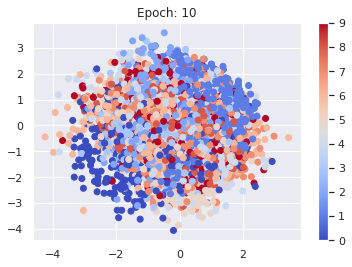

In [ ]:
im = plt.scatter([x[0].numpy() for x in latent_distrs][-1][:, 0], [x[0].numpy() for x in latent_distrs][-1][:, 1], c=test_labels, cmap=cm.coolwarm)
plt.colorbar()
plt.title("Epoch: " + str(epochs[-1]))